In [39]:
!pip install -q -U keras-tuner

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from keras_tuner import RandomSearch
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [41]:
print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  Tesla T4
Using device: cuda


In [42]:
new_df = pd.read_csv('/content/sentiment_scored_.csv')

In [43]:
new_df = new_df.sort_values(by='timestamp')

In [44]:
new_df.drop(columns=['Unnamed: 0'],inplace=True)

### Performing Moving Average

In [45]:
new_df['timestamp'] = pd.to_datetime(new_df['timestamp'], errors='coerce')

In [46]:
new_df['moving_average_neg'] = new_df['rob_neg'].rolling(window=30, min_periods=1).mean()
new_df['moving_average_neu'] = new_df['rob_neu'].rolling(window=30, min_periods=1).mean()
new_df['moving_average_pos'] = new_df['rob_pos'].rolling(window=30, min_periods=1).mean()

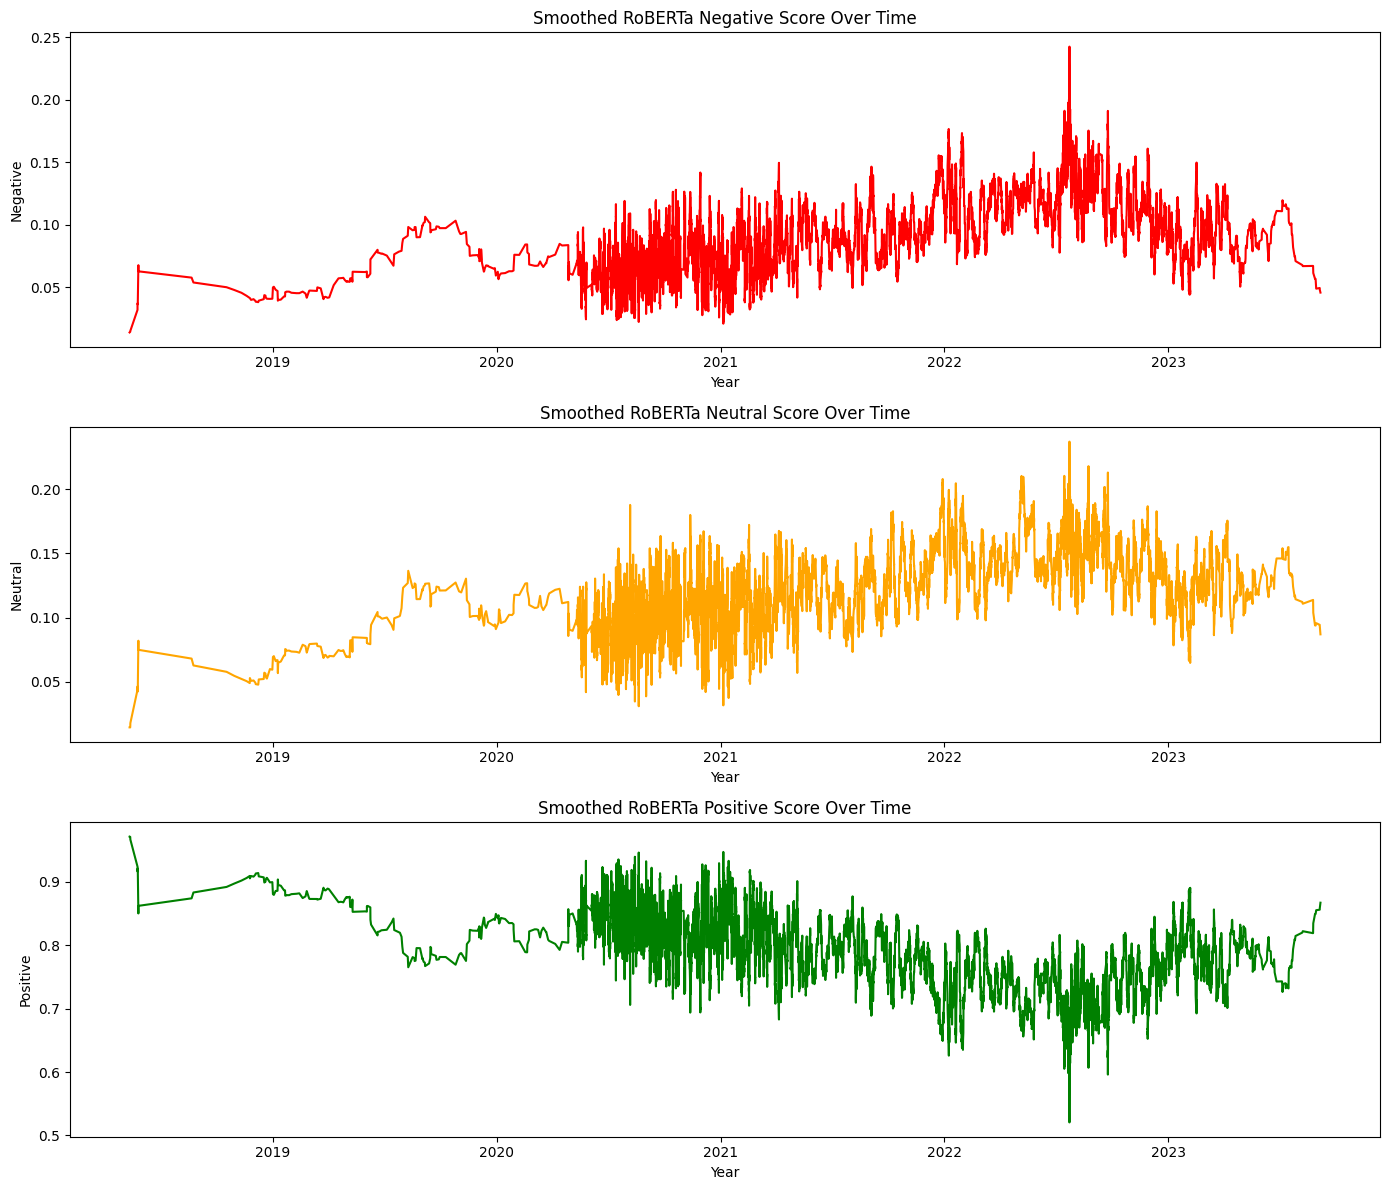

In [47]:
fig, arr = plt.subplots(3, 1, figsize=(14, 12))

arr[0].plot(new_df['timestamp'], new_df['moving_average_neg'], color='red')
arr[0].set_title("Smoothed RoBERTa Negative Score Over Time")
arr[0].set_ylabel("Negative")
arr[0].set_xlabel("Year")

arr[1].plot(new_df['timestamp'], new_df['moving_average_neu'], color='orange')
arr[1].set_title("Smoothed RoBERTa Neutral Score Over Time")
arr[1].set_ylabel("Neutral")
arr[1].set_xlabel("Year")

arr[2].plot(new_df['timestamp'], new_df['moving_average_pos'], color='green')
arr[2].set_title("Smoothed RoBERTa Positive Score Over Time")
arr[2].set_ylabel("Positive")
arr[2].set_xlabel("Year")

plt.tight_layout()
plt.show()


### Creating Class to perform keras tunner

In [48]:
class Forecast_Sentiments:

    def __init__(self):
        self.WINDOW_SIZE = 30
        self.size = None
        self.X = None
        self.y = None
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.cp = None
        self.shape = None
        self.model1 = None
        self.history = None
        self.best_model = None
        self.pos_result = None
        self.earlystopping = EarlyStopping(
                            monitor="val_loss",
                            patience=0,
                            verbose=1,
                            mode="min",)

    def df_to_X_y(self,df,window_Size = 30):
        self.shape = df.shape[0]
        df_as_numpy = df.to_numpy()
        X = []
        y = []
        for i in tqdm(range(len(df_as_numpy) - window_Size)):
            row = [[a] for a in df_as_numpy[i:i + window_Size]]
            X.append(row)
            label = df_as_numpy[i + window_Size]
            y.append(label)

        self.X = np.array(X)
        self.y = np.array(y)

    def split_data_points(self,test_size = 0.2):
        size = int(np.round(self.shape * (1 - test_size)))
        self.X_train , self.y_train = np.array(self.X[:size]), np.array(self.y[:size])
        self.X_test , self.y_test = np.array(self.X[size:]) , np.array(self.y[size:])

    def build_model(self, hp):
        model = Sequential()
        model.add(InputLayer((self.WINDOW_SIZE, 1)))

        num_layers = hp.Int("num_layers", 1, 5)

        for i in range(num_layers):
            model.add(
                LSTM(
                    units=hp.Int(f"lstm_units_{i}", min_value=32, max_value=128, step=32),
                    return_sequences=(i != num_layers - 1)
                )
            )
            model.add(
                Dropout(rate=hp.Float(f"dropout_{i}", min_value=0.1, max_value=0.5, step=0.1))
            )

        model.add(
            Dense(hp.Int("dense_units", min_value=4, max_value=16, step=4), activation='relu')
        )
        model.add(Dense(1, activation='linear'))

        model.compile(
            loss=MeanSquaredError(),
            optimizer=Adam(learning_rate=hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])),
            metrics=[RootMeanSquaredError()]
        )
        return model



    def load_and_use_best_tuned_model(self):
        self.best_model = load_model("model1_best.keras")
        self.model1 = self.best_model
        print("\nSummary of Best Tuned Model:")
        self.model1.summary()


    def tune_hyperparameters(self):
        tuner = RandomSearch(
            self.build_model,
            objective="val_loss",
            max_trials=20,
            executions_per_trial=1,
            directory="tuner_dir",
            project_name="sentiment_forecast"
        )

        early_stop = EarlyStopping(
            monitor="val_loss",
            patience=3,
            verbose=1,
            mode="min",
            restore_best_weights=True
        )

        tuner.search(
            self.X_train,
            self.y_train,
            epochs=50,
            validation_split=0.2,
            callbacks=[early_stop]
        )

        self.best_model = tuner.get_best_models(num_models=1)[0]
        self.best_model.save("model1_best.keras")
        self.model1 = self.best_model
        self.cp = ModelCheckpoint('model1_best.keras', save_best_only=True)

        print("\nTuner Search Summary:")
        tuner.results_summary()

        print("\nBest Model Summary:")
        self.best_model.summary()


    def train_stacked_lstm_model(self, learning_rate=0.001):
        self.model1 = Sequential()
        self.model1.add(InputLayer((self.WINDOW_SIZE, 1)))

        self.model1.add(LSTM(64, return_sequences=True))
        self.model1.add(Dropout(0.2))

        self.model1.add(LSTM(64, return_sequences=True))
        self.model1.add(Dropout(0.2))

        self.model1.add(LSTM(64))
        self.model1.add(Dropout(0.2))

        self.model1.add(Dense(8, activation='relu'))
        self.model1.add(Dense(1, activation='linear'))

        self.model1.summary()

        self.cp = ModelCheckpoint('model1_best.keras', save_best_only=True)

        self.model1.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=learning_rate),metrics=[RootMeanSquaredError()])

    def fit_model(self,epochs = 50):
        self.history = self.model1.fit(
        self.X_train,
        self.y_train,
        validation_split=0.2,
        epochs=epochs,
        callbacks=[self.cp, self.earlystopping]
        )

        plt.figure(figsize=(10, 5))
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Training vs Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    def forecast_model(self):
        self.best_model = load_model('model1_best.keras')
        temp = self.best_model.predict(self.X_test)
        return pd.DataFrame(data = {'Test Prediction' : temp.flatten(),'Actual' : self.y_test})

    def evaluation(self,model):

        mse = mean_squared_error(model['Test Prediction'],model['Actual'])
        rmse = np.sqrt(mse)
        r2 = r2_score(model['Test Prediction'],model['Actual'])
        mae = mean_absolute_error(model['Test Prediction'],model['Actual'])

        print('mse : ',mse)
        print('rmse : ',rmse)
        print('r2 : ',r2)
        print('mae : ',mae)

    def forecast_visual(self,model,text):
        plt.figure(figsize=(12, 5))
        plt.plot(model['Test Prediction'], label='Predicted',alpha=0.8)
        plt.plot(model['Actual'], label='Actual',alpha=0.6)
        plt.title(f'{text} Sentiment Model Prediction vs Actual Values')
        plt.xlabel('Time Step')
        plt.ylabel('Sentiment Score')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()


## Applying Keras Tuner

In [49]:
negative_sentiment = Forecast_Sentiments()
neutral_sentiment = Forecast_Sentiments()
positive_sentiment = Forecast_Sentiments()

### Performing for Negative Sentiment

In [50]:
negative_sentiment.df_to_X_y(new_df['moving_average_neg'])

100%|██████████| 16827/16827 [00:01<00:00, 9858.03it/s]


In [51]:
negative_sentiment.split_data_points()

In [52]:
negative_sentiment.tune_hyperparameters()

Reloading Tuner from tuner_dir/sentiment_forecast/tuner0.json

Tuner Search Summary:
Results summary
Results in tuner_dir/sentiment_forecast
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 03 summary
Hyperparameters:
num_layers: 2
lstm_units_0: 128
dropout_0: 0.30000000000000004
dense_units: 12
learning_rate: 0.01
lstm_units_1: 96
dropout_1: 0.2
lstm_units_2: 32
dropout_2: 0.30000000000000004
lstm_units_3: 128
dropout_3: 0.5
lstm_units_4: 96
dropout_4: 0.1
Score: 9.403881267644465e-05

Trial 10 summary
Hyperparameters:
num_layers: 2
lstm_units_0: 32
dropout_0: 0.1
dense_units: 16
learning_rate: 0.01
lstm_units_1: 64
dropout_1: 0.5
lstm_units_2: 96
dropout_2: 0.1
lstm_units_3: 128
dropout_3: 0.4
lstm_units_4: 96
dropout_4: 0.2
Score: 0.00010142845712834969

Trial 08 summary
Hyperparameters:
num_layers: 1
lstm_units_0: 96
dropout_0: 0.4
dense_units: 8
learning_rate: 0.01
lstm_units_1: 128
dropout_1: 0.4
lstm_units_2: 32
dropout_2: 0.1
lstm_units_3: 96
dropout_3:

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │         1,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,137 (602.10 KB)

 Trainable params: 154,137 (602.10 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# negative_sentiment.fit_model()

In [54]:
negative_sentiment_model = negative_sentiment.forecast_model()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


In [55]:
negative_sentiment.evaluation(negative_sentiment_model)

mse :  3.81643539701577e-05
rmse :  0.006177730487012014
r2 :  0.9429328546026514
mae :  0.004704626790603453


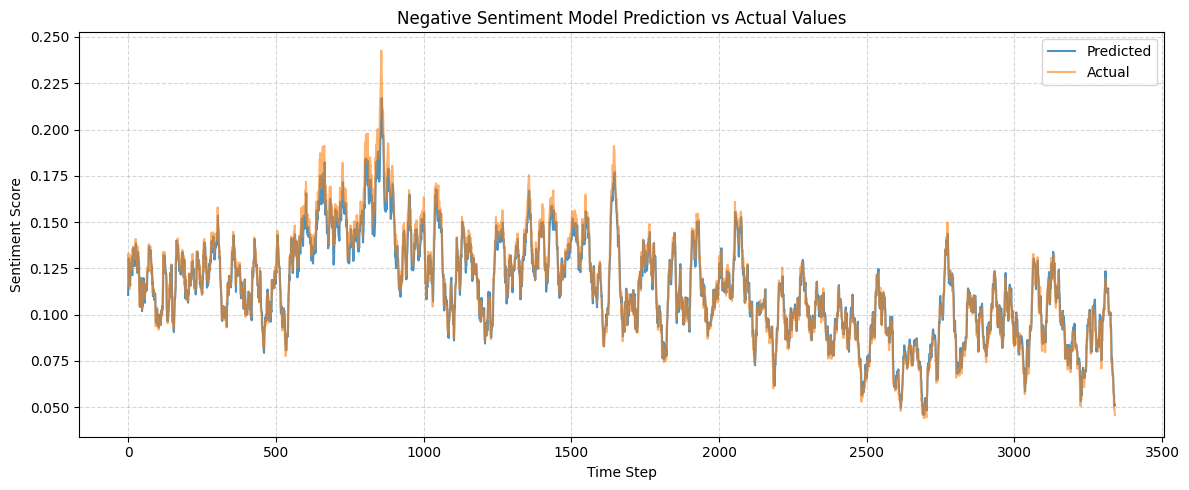

In [56]:
negative_sentiment.forecast_visual(negative_sentiment_model, text='Negative')

### Applying for Neutral Sentiment

In [57]:
neutral_sentiment.tune_hyperparameters()

Reloading Tuner from tuner_dir/sentiment_forecast/tuner0.json

Tuner Search Summary:
Results summary
Results in tuner_dir/sentiment_forecast
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 03 summary
Hyperparameters:
num_layers: 2
lstm_units_0: 128
dropout_0: 0.30000000000000004
dense_units: 12
learning_rate: 0.01
lstm_units_1: 96
dropout_1: 0.2
lstm_units_2: 32
dropout_2: 0.30000000000000004
lstm_units_3: 128
dropout_3: 0.5
lstm_units_4: 96
dropout_4: 0.1
Score: 9.403881267644465e-05

Trial 10 summary
Hyperparameters:
num_layers: 2
lstm_units_0: 32
dropout_0: 0.1
dense_units: 16
learning_rate: 0.01
lstm_units_1: 64
dropout_1: 0.5
lstm_units_2: 96
dropout_2: 0.1
lstm_units_3: 128
dropout_3: 0.4
lstm_units_4: 96
dropout_4: 0.2
Score: 0.00010142845712834969

Trial 08 summary
Hyperparameters:
num_layers: 1
lstm_units_0: 96
dropout_0: 0.4
dense_units: 8
learning_rate: 0.01
lstm_units_1: 128
dropout_1: 0.4
lstm_units_2: 32
dropout_2: 0.1
lstm_units_3: 96
dropout_3:

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │         1,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,137 (602.10 KB)

 Trainable params: 154,137 (602.10 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
neutral_sentiment.df_to_X_y(new_df['moving_average_neu'])

100%|██████████| 16827/16827 [00:01<00:00, 14700.92it/s]


In [59]:
neutral_sentiment.split_data_points()

In [60]:
# neutral_sentiment.fit_model()

In [61]:
neutral_sentiment_model = neutral_sentiment.forecast_model()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


In [62]:
neutral_sentiment.evaluation(neutral_sentiment_model)

mse :  6.225042730293312e-05
rmse :  0.007889893998206384
r2 :  0.8666936941208985
mae :  0.00621349317309063


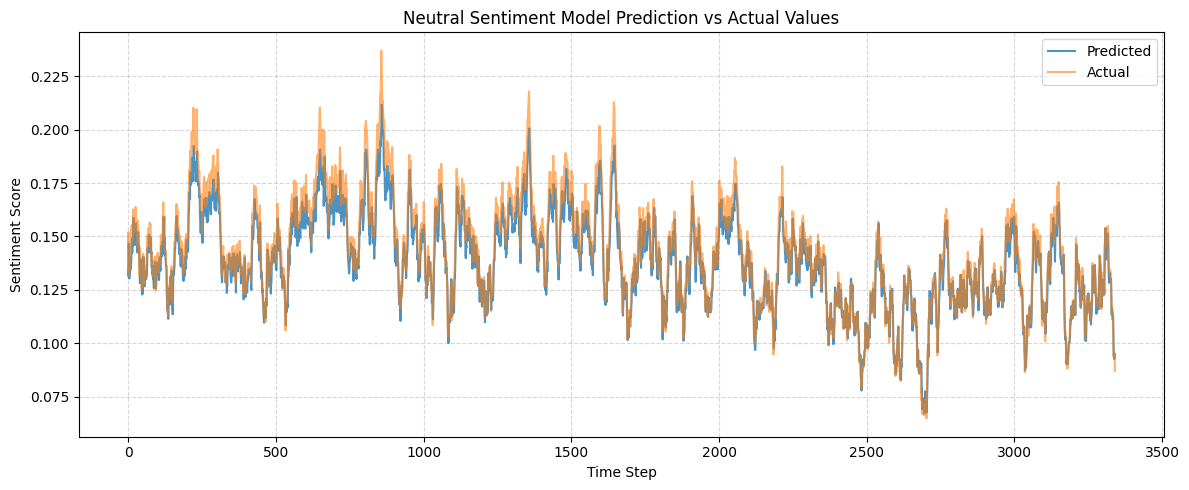

In [63]:
neutral_sentiment.forecast_visual(neutral_sentiment_model, text='Neutral')

### Applying for Positive Sentiment

In [64]:
positive_sentiment.tune_hyperparameters()

Reloading Tuner from tuner_dir/sentiment_forecast/tuner0.json

Tuner Search Summary:
Results summary
Results in tuner_dir/sentiment_forecast
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 03 summary
Hyperparameters:
num_layers: 2
lstm_units_0: 128
dropout_0: 0.30000000000000004
dense_units: 12
learning_rate: 0.01
lstm_units_1: 96
dropout_1: 0.2
lstm_units_2: 32
dropout_2: 0.30000000000000004
lstm_units_3: 128
dropout_3: 0.5
lstm_units_4: 96
dropout_4: 0.1
Score: 9.403881267644465e-05

Trial 10 summary
Hyperparameters:
num_layers: 2
lstm_units_0: 32
dropout_0: 0.1
dense_units: 16
learning_rate: 0.01
lstm_units_1: 64
dropout_1: 0.5
lstm_units_2: 96
dropout_2: 0.1
lstm_units_3: 128
dropout_3: 0.4
lstm_units_4: 96
dropout_4: 0.2
Score: 0.00010142845712834969

Trial 08 summary
Hyperparameters:
num_layers: 1
lstm_units_0: 96
dropout_0: 0.4
dense_units: 8
learning_rate: 0.01
lstm_units_1: 128
dropout_1: 0.4
lstm_units_2: 32
dropout_2: 0.1
lstm_units_3: 96
dropout_3:

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │         1,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,137 (602.10 KB)

 Trainable params: 154,137 (602.10 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
positive_sentiment.df_to_X_y(new_df['moving_average_pos'])

100%|██████████| 16827/16827 [00:00<00:00, 23808.36it/s]


In [66]:
positive_sentiment.split_data_points()

Epoch 1/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0087 - root_mean_squared_error: 0.0859 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0617
Epoch 2/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0012 - root_mean_squared_error: 0.0350 - val_loss: 2.3684e-04 - val_root_mean_squared_error: 0.0154
Epoch 3/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 3.8261e-04 - root_mean_squared_error: 0.0195 - val_loss: 3.0312e-04 - val_root_mean_squared_error: 0.0174
Epoch 3: early stopping


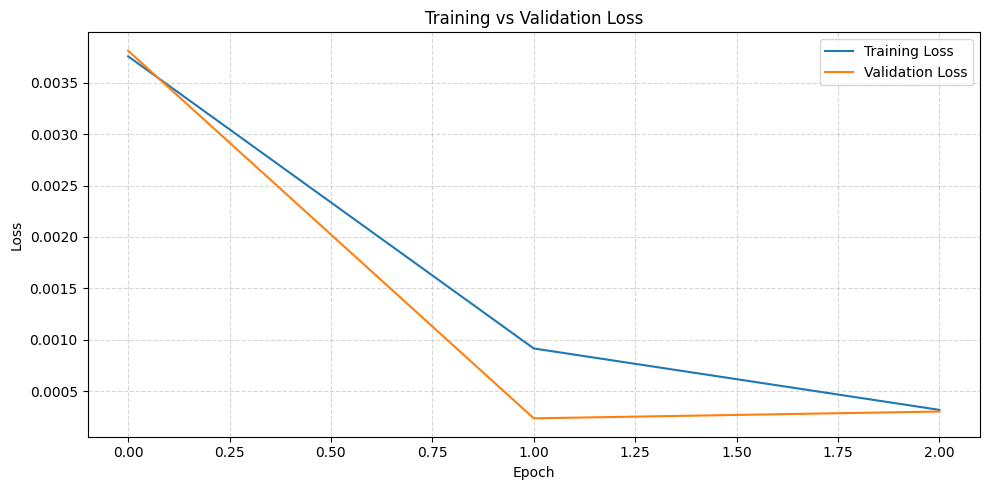

In [67]:
positive_sentiment.fit_model()

In [68]:
positive_sentiment_model = positive_sentiment.forecast_model()

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [69]:
positive_sentiment.evaluation(positive_sentiment_model)

mse :  0.0011633841200356023
rmse :  0.03410841714350876
r2 :  0.765206662304649
mae :  0.016732752565184864


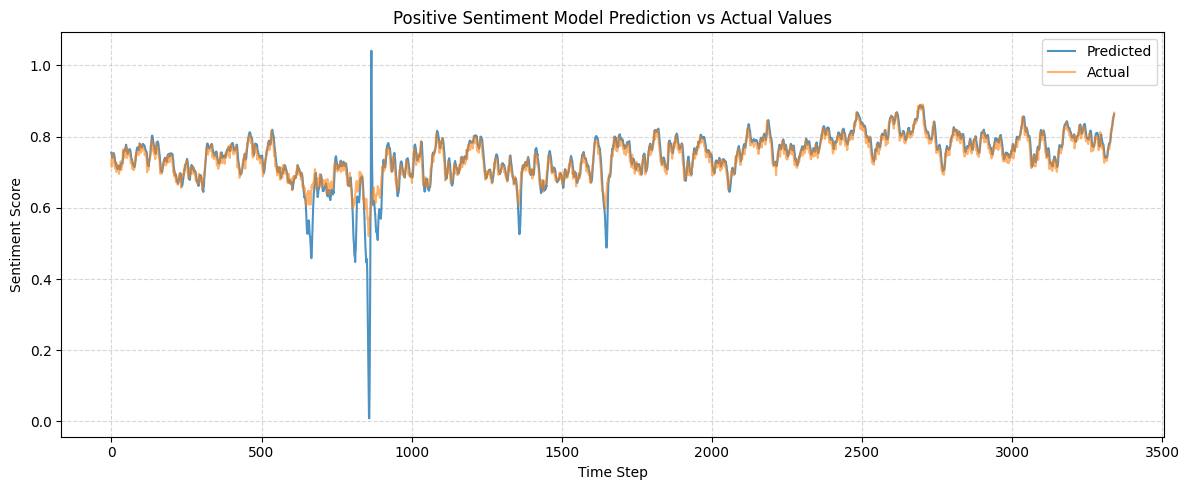

In [70]:
positive_sentiment.forecast_visual(positive_sentiment_model, text='Positive')

### There is some improvement in the model after performing Keras Tuner and applying the best hyperparameter configuration. However, the model still fails to capture the variance effectively. A good R² score is expected to indicate strong model performance.


In [71]:
positive_score = 1 - negative_sentiment_model['Test Prediction'] - neutral_sentiment_model['Test Prediction']

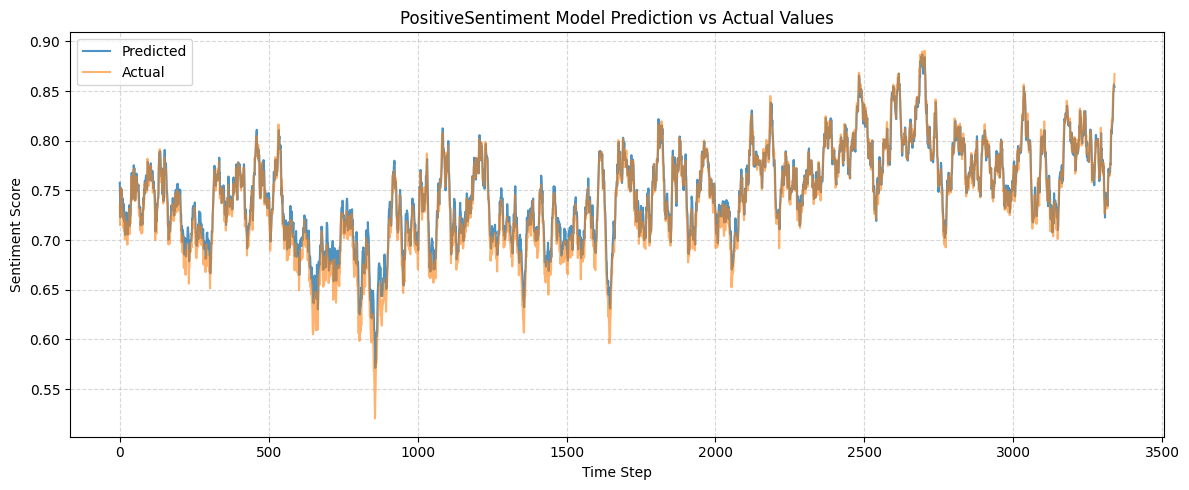

In [72]:
plt.figure(figsize=(12, 5))
plt.plot(positive_score, label='Predicted',alpha=0.8)
plt.plot(positive_sentiment_model['Actual'], label='Actual',alpha=0.6)
plt.title(f'PositiveSentiment Model Prediction vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [73]:
mse = mean_squared_error(positive_score,positive_sentiment_model['Actual'])
rmse = np.sqrt(mse)
r2 = r2_score(positive_score,positive_sentiment_model['Actual'])
mae = mean_absolute_error(positive_score,positive_sentiment_model['Actual'])

print('mse : ',mse)
print('rmse : ',rmse)
print('r2 : ',r2)
print('mae : ',mae)

mse :  0.0001733748480321342
rmse :  0.01316718831156197
r2 :  0.9167591901093914
mae :  0.010223165591843266
